#  Imports

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2
from tensorflow.keras import Model , layers, Sequential
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
import random
from sklearn.model_selection import train_test_split

In [16]:
tf.config.list_physical_devices('GPU')

tf.keras.backend.clear_session()
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Dataset


In [28]:
# Cargar datasets sin etiquetas (sólo imágenes)
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory="e:/TFM/PlantsClassification/train",
    labels=None,
    batch_size=None,
    image_size=(128, 128),
    color_mode="rgb",
    shuffle=True,
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    directory="e:/TFM/PlantsClassification/val",
    labels=None,
    batch_size=None,
    image_size=(128, 128),
    color_mode="rgb",
    shuffle=True,
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory="e:/TFM/PlantsClassification/test",
    labels=None,
    batch_size=None,
    image_size=(128, 128),
    color_mode="rgb",
    shuffle=True,
)
#data augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomContrast(0.2),
    layers.RandomZoom(0.2),
])
# Aplicar data augmentation a las imágenes
train_dataset_triplicado = (
    train_dataset.concatenate(train_dataset.map(lambda x: data_augmentation(x)))
                 .concatenate(train_dataset.map(lambda x: data_augmentation(x)))
)
test_dataset_triplicado = (
    train_dataset.concatenate(train_dataset.map(lambda x: data_augmentation(x)))
                 .concatenate(train_dataset.map(lambda x: data_augmentation(x)))
)

# Función para convertir imagen RGB -> escala de grises (como input) y conservar RGB original como target
def rgb_to_grayscale_input(image):
    image = tf.cast(image, tf.float32) / 255.0  # Normalización a [0, 1]
    gray = tf.image.rgb_to_grayscale(image)
    gray = tf.image.grayscale_to_rgb(gray)  # Asegura que tiene shape (H, W, 3)
    return gray, image  # (input, target)

# Aplicar el mapeo, batching, prefetching
colorization_train_dataset = train_dataset_triplicado.map(rgb_to_grayscale_input).shuffle(1000).batch(8).prefetch(tf.data.AUTOTUNE)
colorization_val_dataset = val_dataset.map(rgb_to_grayscale_input).batch(8).prefetch(tf.data.AUTOTUNE)
colorization_test_dataset = test_dataset_triplicado.map(rgb_to_grayscale_input).batch(8).prefetch(tf.data.AUTOTUNE)

# lenth of datasets
print(len(colorization_train_dataset))
print(len(colorization_val_dataset))
print(len(colorization_test_dataset))


Found 21000 files belonging to 1 classes.
Found 3000 files belonging to 1 classes.
Found 6000 files belonging to 1 classes.
7875
375
7875


In [29]:

def unet(input_shape=(128, 128, 1)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation="relu", padding="same")(inputs)
    c1 = layers.Conv2D(64, 3, activation="relu", padding="same")(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, 3, activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(128, 3, activation="relu", padding="same")(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, 3, activation="relu", padding="same")(p2)
    c3 = layers.Conv2D(256, 3, activation="relu", padding="same")(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, 3, activation="relu", padding="same")(p3)
    c4 = layers.Conv2D(512, 3, activation="relu", padding="same")(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    bn = layers.Conv2D(1024, 3, activation="relu", padding="same")(p4)
    bn = layers.Conv2D(1024, 3, activation="relu", padding="same")(bn)

    # Decoder
    u1 = layers.Conv2DTranspose(512, 2, strides=(2, 2), padding="same")(bn)
    u1 = layers.concatenate([u1, c4])
    c5 = layers.Conv2D(512, 3, activation="relu", padding="same")(u1)
    c5 = layers.Conv2D(512, 3, activation="relu", padding="same")(c5)

    u2 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding="same")(c5)
    u2 = layers.concatenate([u2, c3])
    c6 = layers.Conv2D(256, 3, activation="relu", padding="same")(u2)
    c6 = layers.Conv2D(256, 3, activation="relu", padding="same")(c6)

    u3 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding="same")(c6)
    u3 = layers.concatenate([u3, c2])
    c7 = layers.Conv2D(128, 3, activation="relu", padding="same")(u3)
    c7 = layers.Conv2D(128, 3, activation="relu", padding="same")(c7)

    u4 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding="same")(c7)
    u4 = layers.concatenate([u4, c1])
    c8 = layers.Conv2D(64, 3, activation="relu", padding="same")(u4)
    c8 = layers.Conv2D(64, 3, activation="relu", padding="same")(c8)

    # Output: 3-channel RGB image with sigmoid (for [0,1] range)
    outputs = layers.Conv2D(3, (1, 1), activation="sigmoid", padding="same")(c8)

    return Model(inputs, outputs, name="U-Net_Colorization")


unet_model = unet((128, 128, 3))


unet_model.summary()

Model: "U-Net_Colorization"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 128, 128, 64  36928       ['conv2d_19[0][0]']              
                                )                                                

In [30]:
def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

In [32]:
def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)
unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="mse",metrics=["mae", psnr, ssim])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_unet_colorization.h5", save_best_only=True, monitor="val_loss"),
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1),
]
history = unet_model.fit(
    colorization_train_dataset,  # tf.data.Dataset o generator
    verbose=1,  # Mostrar progreso
    validation_data=colorization_test_dataset,  # validación con rotaciones también
    epochs=50,
    batch_size=8,  # Puedes probar 64 o 128 según tu GPU
    callbacks=callbacks,
)
save_path = "best_unet2_colorization.h5"


Epoch 1/50
7875/7875 [==============================] - 851s 107ms/step - loss: 0.0115 - mae: 0.0714 - psnr: 20.7472 - ssim: 0.8943 - val_loss: 0.0115 - val_mae: 0.0713 - val_psnr: 20.7431 - val_ssim: 0.8942 - lr: 0.0010
Epoch 2/50
7875/7875 [==============================] - 848s 108ms/step - loss: 0.0113 - mae: 0.0700 - psnr: 20.8729 - ssim: 0.8957 - val_loss: 0.0112 - val_mae: 0.0694 - val_psnr: 20.8998 - val_ssim: 0.8974 - lr: 0.0010
Epoch 3/50
7875/7875 [==============================] - 821s 104ms/step - loss: 0.0112 - mae: 0.0694 - psnr: 20.9218 - ssim: 0.8955 - val_loss: 0.0112 - val_mae: 0.0696 - val_psnr: 20.9085 - val_ssim: 0.8962 - lr: 0.0010
Epoch 4/50
7875/7875 [==============================] - 803s 102ms/step - loss: 0.0111 - mae: 0.0692 - psnr: 20.9483 - ssim: 0.8949 - val_loss: 0.0112 - val_mae: 0.0682 - val_psnr: 21.0405 - val_ssim: 0.8965 - lr: 0.0010
Epoch 5/50
7875/7875 [==============================] - 812s 103ms/step - loss: 0.0111 - mae: 0.0689 - psnr: 20.9733

KeyboardInterrupt: 

<Figure size 1200x1200 with 0 Axes>

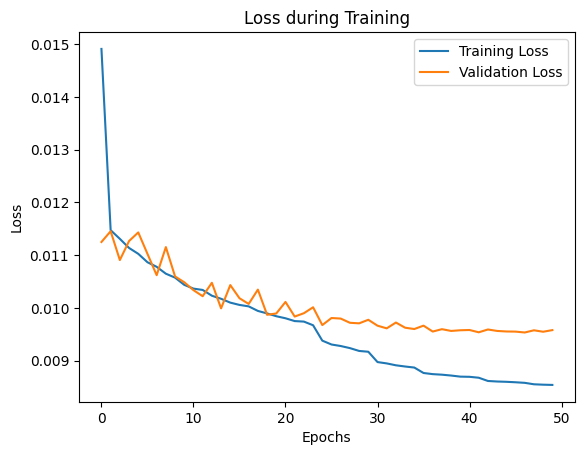

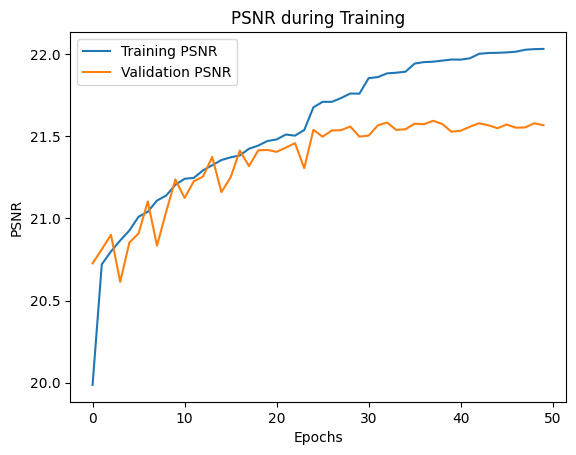

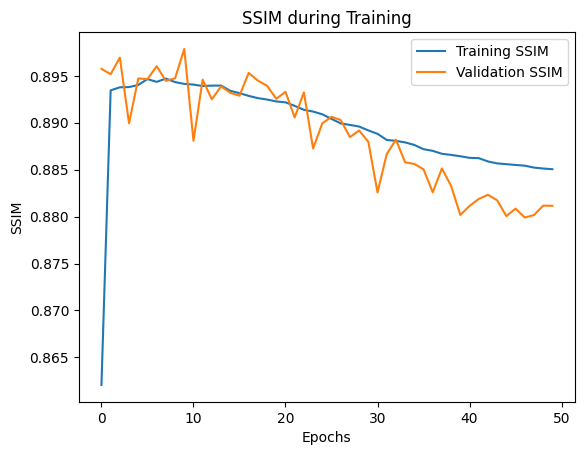

In [19]:
def plot_training_history(history):
    plt.figure(figsize=(12, 12))
    
    # Pérdida
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss during Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # PSNR
    plt.figure()
    plt.plot(history.history['psnr'], label='Training PSNR')
    plt.plot(history.history['val_psnr'], label='Validation PSNR')
    plt.title('PSNR during Training')
    plt.xlabel('Epochs')
    plt.ylabel('PSNR')
    plt.legend()
    plt.show()

    # SSIM
    plt.figure()
    plt.plot(history.history['ssim'], label='Training SSIM')
    plt.plot(history.history['val_ssim'], label='Validation SSIM')
    plt.title('SSIM during Training')
    plt.xlabel('Epochs')
    plt.ylabel('SSIM')
    plt.legend()
    plt.show()

# Llamar a la función para graficar el progreso del entrenamiento
plot_training_history(history)

1/1 [==============================] - 0s 30ms/step


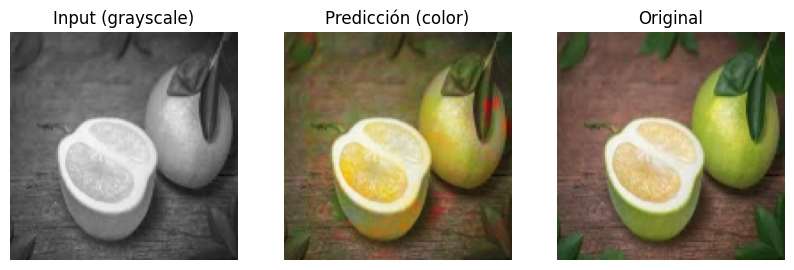

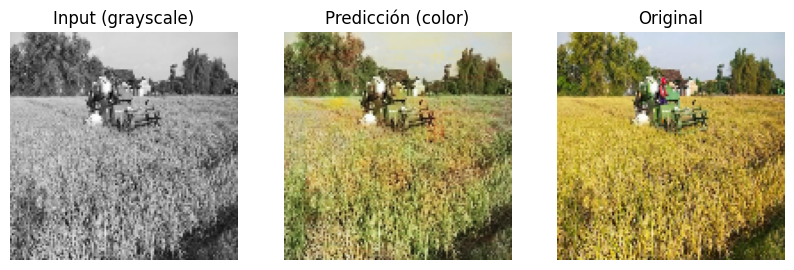

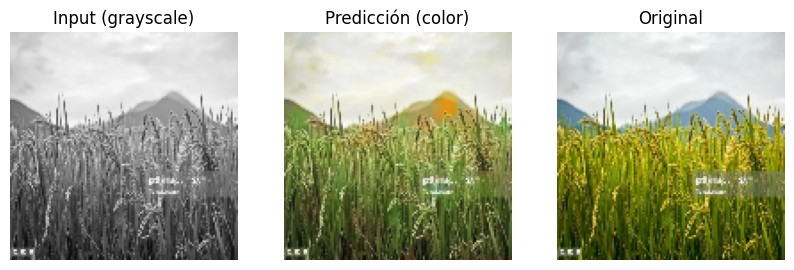

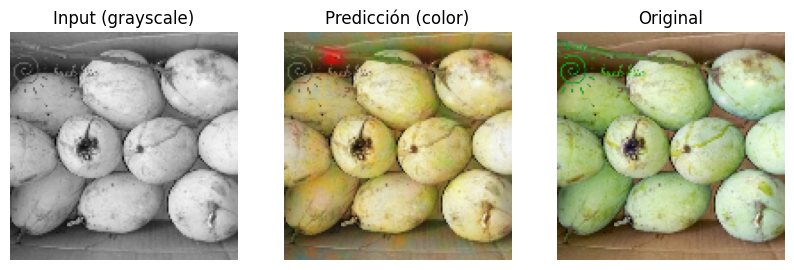

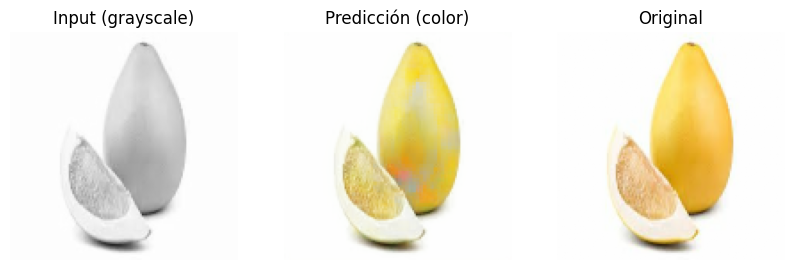

In [22]:
def show_colorization_examples(dataset, model, n=5):
    for images_gray, images_real in dataset.take(1):
        preds = model.predict(images_gray)

        for i in range(n):
            plt.figure(figsize=(10, 3))

            plt.subplot(1, 3, 1)
            plt.imshow(images_gray[i])
            plt.title("Input (grayscale)")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(preds[i])
            plt.title("Predicción (color)")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(images_real[i])
            plt.title("Original")
            plt.axis("off")

            plt.show()
show_colorization_examples(colorization_val_dataset, unet_model, n=5)

In [12]:
classification_train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory="e:/TFM/PlantsClassification/train",
    image_size=(128, 128),
    batch_size=64,
    label_mode="int",
    color_mode="rgb",
    shuffle=True
).map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y)).prefetch(tf.data.AUTOTUNE)

classification_val_dataset = tf.keras.utils.image_dataset_from_directory(
    directory="e:/TFM/PlantsClassification/val",
    image_size=(128, 128),
    batch_size=64,
    label_mode="int",
    color_mode="rgb",
    shuffle=False
).map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y)).prefetch(tf.data.AUTOTUNE)

classification_test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory="e:/TFM/PlantsClassification/test",
    image_size=(128, 128),
    batch_size=64,
    label_mode="int",
    color_mode="rgb",
    shuffle=False
).map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y)).prefetch(tf.data.AUTOTUNE)


Found 21000 files belonging to 30 classes.
Found 3000 files belonging to 30 classes.
Found 6000 files belonging to 30 classes.


In [13]:
model = tf.keras.models.load_model("best_unet2_colorization.h5", custom_objects={'psnr': psnr, 'ssim': ssim})
autoencoder=model
autoencoder.trainable = False
autoencoder.summary()

OSError: No file or directory found at best_unet2_colorization.h5

In [ ]:
# def get_encoder(autoencoder):
#     # Extraemos las capas del encoder (hasta MaxPooling2D final)
#     for layer in autoencoder.layers:
#         layer.trainable = False
#     encoder = tf.keras.Sequential(autoencoder.layers[:13])
#     for layer in encoder.layers:
#         layer.trainable = False
#     return encoder
# encoder = get_encoder(model)
encoder_output = autoencoder.layers[13].output  # cuello en 13
encoder_model = Model(inputs=autoencoder.input, outputs=encoder_output, name="UNet_Encoder")
encoder_model.trainable = False  # congelar
#descongela las ultimas  4 capas
encoder_model.summary()

Model: "UNet_Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 128)       147584    
                                                      

In [ ]:
def create_classifier(encoder, num_classes=30, train_encoder=False):
    for layer in encoder.layers:
        layer.trainable = False

    model = tf.keras.Sequential([
        tf.keras.Input(shape=(128, 128, 3)),
        encoder,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.3),
        layers.BatchNormalization(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model


In [ ]:


classifier = create_classifier(encoder_model, num_classes=30, train_encoder=False)
classifier.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UNet_Encoder (Functional)   (None, 8, 8, 1024)        9404992   
                                                                 
 global_average_pooling2d_3   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_8 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_10 (Dense)            (None, 512)               524800    
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 batch_normalization_9 (Batc  (None, 512)             

In [ ]:



# classifier.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
#     loss='sparse_categorical_crossentropy',
#     metrics=['accuracy']
# )

# history=classifier.fit(
#     classification_train_dataset,  # dataset con labels
#     validation_data=classification_val_dataset,
#     epochs=50,
#     batch_size=64,
#     callbacks=[
#         tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True,verboe=1),
#         tf.keras.callbacks.ModelCheckpoint("best_unetr.h5", save_best_only=True)
#     ]
# )
classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = classifier.fit(
    classification_train_dataset,
    validation_data=classification_val_dataset,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, verbose=1),
        tf.keras.callbacks.ModelCheckpoint("best_unet_classifier.h5", save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5,factor=0.5, min_lr=1e-6, verbose=1)
    ]
)
# save
classifier.save("best_classifier_unet2.h5")



Epoch 1/100
329/329 [==============================] - 22s 61ms/step - loss: 1.5561 - accuracy: 0.5368 - val_loss: 2.2144 - val_accuracy: 0.4197 - lr: 0.0010
Epoch 2/100
329/329 [==============================] - 20s 61ms/step - loss: 1.6055 - accuracy: 0.5228 - val_loss: 2.0851 - val_accuracy: 0.4387 - lr: 0.0010
Epoch 3/100
329/329 [==============================] - 20s 60ms/step - loss: 1.5832 - accuracy: 0.5280 - val_loss: 2.1043 - val_accuracy: 0.4560 - lr: 0.0010
Epoch 4/100
329/329 [==============================] - 20s 60ms/step - loss: 1.5371 - accuracy: 0.5424 - val_loss: 2.1405 - val_accuracy: 0.4430 - lr: 0.0010
Epoch 5/100
329/329 [==============================] - 20s 60ms/step - loss: 1.5290 - accuracy: 0.5405 - val_loss: 2.1460 - val_accuracy: 0.4420 - lr: 0.0010
Epoch 6/100
329/329 [==============================] - 20s 60ms/step - loss: 1.5116 - accuracy: 0.5528 - val_loss: 2.1150 - val_accuracy: 0.4397 - lr: 0.0010
Epoch 7/100
329/329 [==============================]

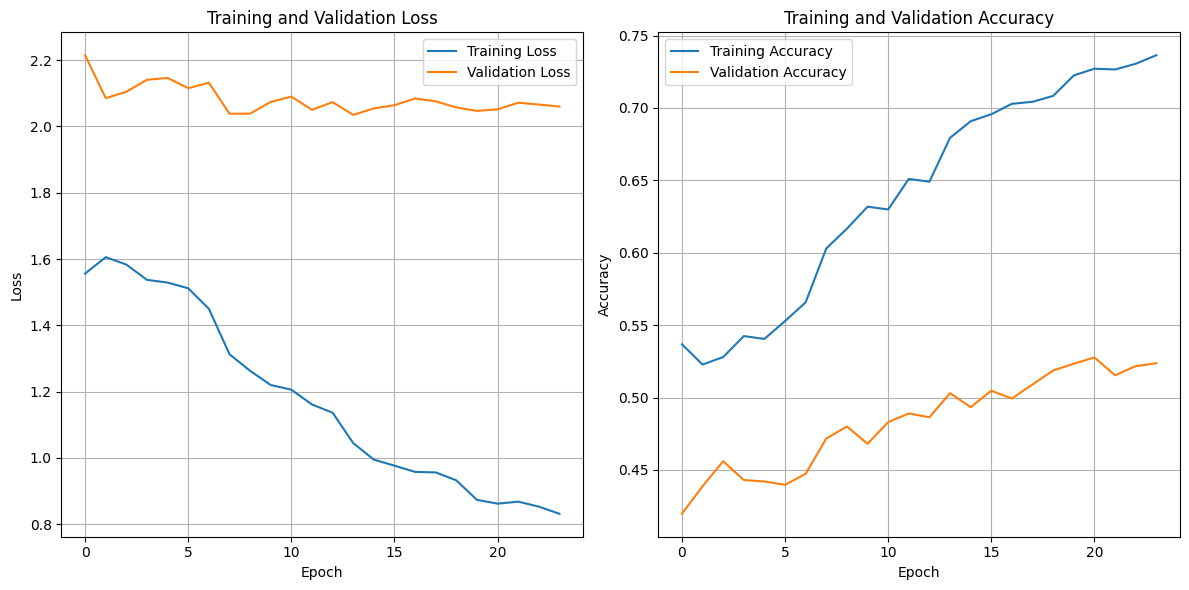

In [ ]:
plt.figure(figsize=(12, 6))

# Gráfico de pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()

# Gráfico de precisión
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


2/2 [==============================] - 0s 23ms/step


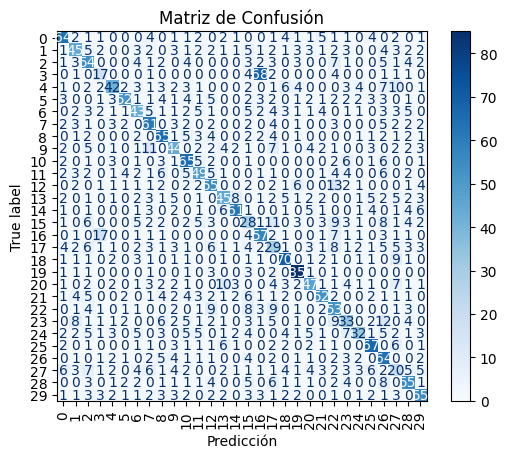

F1 Score: 0.4991
Accuracy: 0.5030
Precision: 0.5090
Recall: 0.5030


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Obtener predicciones y etiquetas verdaderas
y_true = []
y_pred = []

for images, labels in classification_val_dataset:
    predictions = classifier.predict(images)  # Use the correct classifier model
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Asegúrate de que y_true y y_pred sean listas de enteros
y_true = np.array(y_true, dtype=int)
y_pred = np.array(y_pred, dtype=int)

# Crear la matriz de confusión
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(30))  # Ajusta el rango según tus clases
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.xlabel("Predicción")
plt.title("Matriz de Confusión")
plt.show()

#f1 score
from sklearn.metrics import f1_score
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")
#accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")
#precision
from sklearn.metrics import precision_score
precision = precision_score(y_true, y_pred, average='weighted')
print(f"Precision: {precision:.4f}")
#recall
from sklearn.metrics import recall_score
recall = recall_score(y_true, y_pred, average='weighted')
print(f"Recall: {recall:.4f}")


In [ ]:
# Obtener las etiquetas de las carpetas en el directorio de validación
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
val_dir = "e:/TFM/PlantsClassification/val"
class_labels = sorted(os.listdir(val_dir))  # Asegúrate de que las carpetas estén ordenadas alfabéticamente

# Crear la matriz de confusión con etiquetas personalizadas
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Verdadera")
plt.title("Matriz de Confusión")
plt.show()


NameError: name 'os' is not defined